---



# <font color='#ECA702'>**Análisis Multimodal de Síntomas en la Enfermedad de Parkinson**</font>

In [2]:
#@title **Importar librerías**

# Manipulación de datos
import os
import cv2
import numpy as np
import librosa
import pandas as pd
from zipfile import ZipFile

# Pytorch essentials
import torch
import torch.nn as nn
import torch.nn.functional as F

# Pytorch essentials for datasets.
from torch.utils.data import Dataset, DataLoader, ConcatDataset

# Utils
import matplotlib.pyplot as plt
from tqdm import tqdm
from datetime import datetime
import pytz
import copy

# sklearn
from sklearn.model_selection import GroupKFold
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

In [3]:
#@title **Cargamos los datos desde Drive**

from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/data_parkinson')
print(os.getcwd())

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/1XRruCPRodR4OhRCRZYKsyODqa_GuBkfC/data_parkinson


In [4]:
#@title **Extraer el zip**

os.mkdir('../../../../data')
os.popen('cp data.csv ../../../../data/data.csv')
target_path = os.path.join('../../../../data') # Aquí es donde van a quedar los datos
# deben quedar fuera de drive para poder acceder a ellos 'localmente'

# Unzip the downloaded files
zip_file_path = os.path.join('AudioVisualData_v7.zip')
with ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(target_path)

# # Me muevo hasta donde quedaron los datos
%cd ../../../../data
# Verifico
%ls

/content/data
AudioVisualData_v7/  data.csv


## <font color='#4C5FDA'>**Procesamiento del dataset**</font>

### <font color='#52F17F'>**Creación del Dataset Pandas auxiliar**</font>

In [3]:
data = pd.read_csv("data.csv", index_col='patient')

def string2array(string: str):
  """ Convierte un string con datos a numpy array """
  string = string.strip('[]')
  return np.fromstring(string, sep=',')

data['flatten_log_mel_spectogram'] = data['flatten_log_mel_spectogram'].apply(string2array)
data.head()

,audio_path,frames_path,label,flatten_log_mel_spectogram
patient,,,,
C2,AudioVisualData_v7/Control/C2/Vowels/audio/C2-...,AudioVisualData_v7/Control/C2/Vowels/frames/C2...,0.0,"[-60.66636657714844, -19.715749740600586, -24...."
C2,AudioVisualData_v7/Control/C2/Vowels/audio/C2-...,AudioVisualData_v7/Control/C2/Vowels/frames/C2...,0.0,"[-61.8838005065918, -28.279430389404297, -28.8..."
C2,AudioVisualData_v7/Control/C2/Vowels/audio/C2-...,AudioVisualData_v7/Control/C2/Vowels/frames/C2...,0.0,"[-59.091400146484375, -25.001014709472656, -28..."
C2,AudioVisualData_v7/Control/C2/Vowels/audio/C2-...,AudioVisualData_v7/Control/C2/Vowels/frames/C2...,0.0,"[-60.556915283203125, -20.145050048828125, -20..."
C2,AudioVisualData_v7/Control/C2/Vowels/audio/C2-...,AudioVisualData_v7/Control/C2/Vowels/frames/C2...,0.0,"[-69.82708740234375, -20.313282012939453, -26...."


### <font color='#52F17F'>**Creación del Dataset PyTorch**</font>

In [4]:
"""
Constante sacada de la media de cantidad de frames de todos los vídeos multiplicada por 0.1
para tener el 10%
"""

FRAMES_PROMEDIO = 14

In [5]:
class PatientDataset(Dataset):
  def __init__(self, dataframe, n_frames = FRAMES_PROMEDIO):
    self.dataframe = dataframe
    # self.transform = transform
    self.n_frames = n_frames
    # self.audios = sorted(os.listdir(audio_dir)) # Listamos todas las imagenes en la carpeta

  def __len__(self):
    return len(self.dataframe)

  def __getitem__(self, index):

    """ Carga de la imagen """

    # Entramos a la carpeta y conseguimos el audio de la lista
    # audio_path = os.path.join(self.audio_dir, self.audios[index])
    # audio_path = os.path.join(self.dataframe['audio_path'][index])

    # Leemos el audio
    audio = self.dataframe['flatten_log_mel_spectogram'][index].astype(np.float32)
    audio = audio.reshape((90, 10))
    audio = torch.from_numpy(audio).unsqueeze(0)

    """ Carga de los frames """

    # Entramos a la carpeta y conseguimos los frames de la lista.
      # La razon por la que uso la misma lista de audios es porque el audio y el vídeo
      # tienen el mismo nombre, solo cambia la ruta de la carpeta y la extensión.
    """ audios: AudioVisualData_v7/Control/C0/Phonemes/audio/C0-1-Pakata.mp3 """
    """ vídeo: AudioVisualData_v7/Control/C0/Phonemes/frames/C0-1-Pakata.mov """
    video_path = os.path.join(self.dataframe['frames_path'][index])
    # video_path = os.path.join(self.video_dir, self.audios[index].replace(".mp3", ".mov"))

    frames_path = sorted(os.listdir(video_path))[:self.n_frames]
    frames = []
    for frame in frames_path:
      frame_path = os.path.join(self.dataframe['frames_path'][index], frame)
      # print(frame_path)
      frame = cv2.imread(frame_path, cv2.IMREAD_GRAYSCALE)
      frame = cv2.resize(frame, (112, 112)) # Resize a 112x112
      frame = frame / 255. # Normalizamos entre 0 y 1
      frames.append(frame)

    frames = np.expand_dims(np.stack(frames), axis=1).astype('float32')
    frames = frames.transpose(1, 0, 2, 3)
    frames = torch.from_numpy(frames)

    """ Consiguiendo el label """

    # Para conseguir la etiqueta simplemente me tengo que fijar en la ruta. Si es 'Parkinson' 1
    # sino 0.

    label = 1 if 'Parkinson' in self.dataframe['audio_path'][index] else 0

    return audio, frames, label

In [6]:
complete_dataset = PatientDataset(data)
print(complete_dataset.__len__())
print(complete_dataset[0][0].shape, complete_dataset[0][1].shape , complete_dataset[0][2])

1091
torch.Size([1, 90, 10]) torch.Size([1, 14, 112, 112]) 0


### <font color='#52F17F'>**Visualización de los datos**</font>

In [6]:
def plot_frame_strip(frames, rows=2, cols=7):
    """
    Hace un plot de la tira de frames en una matriz de imágenes.

    Args:
        frames (np.ndarray): Tensor de frames con forma (num_frames, height, width, channels).
        rows (int): Número de filas en la tira de frames.
        cols (int): Número de columnas en la tira de frames.
    """
    fig, axes = plt.subplots(rows, cols, figsize=(20, 6))

    for i in range(rows):
        for j in range(cols):
            idx = i * cols + j
            if idx < len(frames):
                axes[i, j].imshow(frames[idx], cmap='gray')
                axes[i, j].axis('off')
                axes[i, j].set_title(f"Frame: {idx}")
    plt.show()

In [ ]:
plot_frame_strip(complete_dataset[0][1].squeeze(0).numpy())

In [8]:
complete_dataset[0][0].squeeze(0).numpy().reshape((90, 10)).shape

(90, 10)

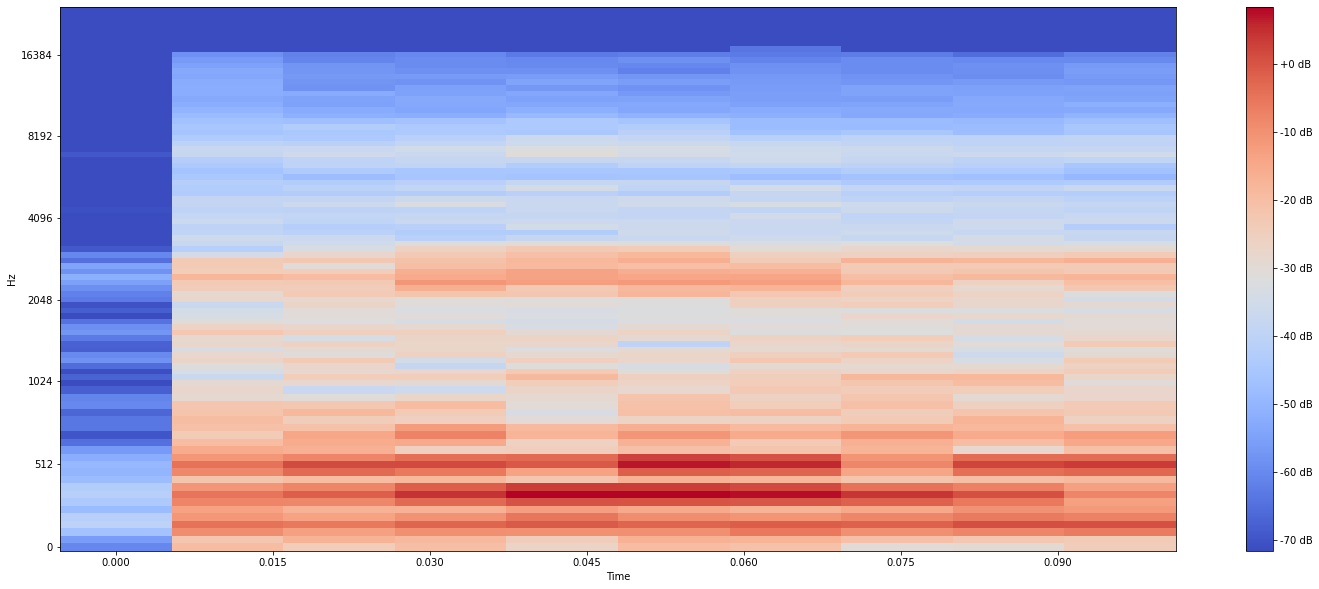

In [9]:
plt.figure(figsize=(25,10))
librosa.display.specshow(complete_dataset[0][0].squeeze(0).numpy(), y_axis='mel', x_axis='time', sr=48000)
plt.colorbar(format="%+2.f dB")
plt.show()

### <font color='#52F17F'>**Partición de los datos**</font>

In [7]:
# Extraer los datos para GroupKFold https://discuss.pytorch.org/t/custom-datatype-for-many-images-to-one-label/87629
X = [i for i in range(len(data))]
y = data['label'].values
groups = data.index.values

In [8]:
groupk_folds = 7
gkf = GroupKFold(n_splits=groupk_folds)
# Realizar la validación cruzada por grupos
for i, (train_index, test_index) in enumerate(gkf.split(X, y, groups), 1):
    train_groups = groups[train_index]
    test_groups = groups[test_index]

    print(f"División {i}:")
    print("  Pacientes en entrenamiento:", np.unique(train_groups))
    print("  Pacientes en prueba:", np.unique(test_groups))
    print("  Número de pacientes en entrenamiento:", len(np.unique(train_groups)))
    print("  Número de pacientes en prueba:", len(np.unique(test_groups)))
    print()

División 1:
  Pacientes en entrenamiento: ['C0' 'C1' 'C2' 'C3' 'C4' 'C6' 'P0' 'P1' 'P4' 'P5' 'P6' 'P7']
  Pacientes en prueba: ['C5' 'P8']
  Número de pacientes en entrenamiento: 12
  Número de pacientes en prueba: 2

División 2:
  Pacientes en entrenamiento: ['C0' 'C1' 'C2' 'C3' 'C5' 'C6' 'P0' 'P1' 'P4' 'P5' 'P6' 'P8']
  Pacientes en prueba: ['C4' 'P7']
  Número de pacientes en entrenamiento: 12
  Número de pacientes en prueba: 2

División 3:
  Pacientes en entrenamiento: ['C0' 'C1' 'C2' 'C4' 'C5' 'C6' 'P0' 'P1' 'P4' 'P5' 'P7' 'P8']
  Pacientes en prueba: ['C3' 'P6']
  Número de pacientes en entrenamiento: 12
  Número de pacientes en prueba: 2

División 4:
  Pacientes en entrenamiento: ['C0' 'C1' 'C3' 'C4' 'C5' 'C6' 'P0' 'P1' 'P4' 'P6' 'P7' 'P8']
  Pacientes en prueba: ['C2' 'P5']
  Número de pacientes en entrenamiento: 12
  Número de pacientes en prueba: 2

División 5:
  Pacientes en entrenamiento: ['C0' 'C2' 'C3' 'C4' 'C5' 'C6' 'P0' 'P1' 'P5' 'P6' 'P7' 'P8']
  Pacientes en prueba: [

## <font color='#ECA702'>**Modelo Fully Conected**</font>

### <font color='#52F17F'>**Creando el modelo**</font>

In [9]:
class MultimodalModel(nn.Module):
  def __init__(self, n_channels):
    super().__init__()
    # self.audio_model = AudioModule(n_channels, n_classes)
    # self.video_model = VideoModule(n_channels, n_classes)
    self.fc1 = nn.Linear((1 * 14 * 112 * 112) + (1 * 90 * 10), 128)
    self.fc2 = nn.Linear(128, 64)
    self.fc3 = nn.Linear(64, 32)
    self.fc4 = nn.Linear(32, 1)  # Suponiendo que es una tarea de clasificación binaria

  def forward(self, audio, video):
    # https://stackoverflow.com/questions/42479902/what-does-view-do-in-pytorch
    audio = audio.view(audio.size(0), -1) # Aplane los audios conservando el batch
    # devuelve: # batch_size x (90*10)

    video = video.view(video.size(0), -1) # Aplane los videos conservando el batch
    # devuelve: # batch_size x (14*112*112)

    combined = torch.cat((video, audio), dim=1) # https://pytorch.org/docs/stable/generated/torch.cat.html
    x = F.relu(self.fc1(combined))
    x = F.relu(self.fc2(x))
    x = F.relu(self.fc3(x))
    x = self.fc4(x)
    return x

In [10]:
# Test al modelo, para ver si nos entrega la salida esperada

n_channels = 1
n_classes = 2
input_audio = complete_dataset[0][0].unsqueeze(0)
input_video = complete_dataset[0][1].unsqueeze(0)
print(f"Entrada audio: {input_audio.size(), input_audio.dtype}")
print(f"Entrada video: {input_video.size(), input_video.dtype}")

model = MultimodalModel(n_channels=n_channels)
ouput = model(input_audio, input_video)
print(f"Salida: {ouput.size()}")

Entrada audio: (torch.Size([1, 1, 90, 10]), torch.float32)
Entrada video: (torch.Size([1, 1, 14, 112, 112]), torch.float32)
Salida: torch.Size([1, 1])


In [11]:
# Test al modelo, para ver si nos entrega la salida esperada

n_channels = 1
n_classes = 2
input_video = torch.rand([2, 1, 14, 112, 112])
input_audio = torch.rand([2, 1, 90, 10])

print(f"Entrada audio: {input_audio.size(), input_audio.dtype}")
print(f"Entrada video: {input_video.size(), input_video.dtype}")

model = MultimodalModel(n_channels=n_channels)
ouput = model(input_audio, input_video)
print(f"Salida: {ouput.size()}")

Entrada audio: (torch.Size([2, 1, 90, 10]), torch.float32)
Entrada video: (torch.Size([2, 1, 14, 112, 112]), torch.float32)
Salida: torch.Size([2, 1])


### <font color='#52F17F'>**Entrenamiento del modelo**</font>

In [103]:
# Hiperparametros
LEARNING_RATE = 0.0001
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 32

In [104]:
# For fold results

# Acá vamos a guardar las métricas del modelo
results = {
    "accuracy": [],
    "recall": [],
    "precision": [],
    "f1_score": []
}

# Storage for plotting
losses_per_epoch = []
vlosses_per_epoch = []

# Esto es para guardar los modelos de cada experimento en carpetas separadas
timezone = pytz.timezone('America/Bogota')
timestamp = datetime.now(timezone).strftime('%Y%m_%d_%H%M')
exp_path = f'../models/exp_{timestamp}'
figures_exp_path = f'../reports/figures/exp_{timestamp}'
os.mkdir(exp_path)
os.mkdir(figures_exp_path)

In [88]:
#@title **training loop**

def train_one_epoch(trainloader, model, optimizer, criterion, losses):
  n_prints = int(len(trainloader)/1)
  running_loss = 0.0
  for i, data in enumerate(tqdm(trainloader, 0)):
    # get the inputs; data is a list of [inputs, labels]
    audios, videos, labels = data

    # Movemos los datos al device
    audios = audios.to(DEVICE)
    videos = videos.to(DEVICE)
    labels = labels.unsqueeze(1).float() #convert target to same nn output shape
    labels = labels.to(DEVICE)

    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    outputs = model(audios, videos)
    # print(ouputs.dtype)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    # print statistics
    running_loss += loss.item()
    if i % n_prints == n_prints-1:    # print every n_print mini-batches
      tqdm.write(f'batch {i + 1} loss: {running_loss / (i + 1):.4f}')
      # Store loss per epoch
      losses.append(np.round(running_loss / (i+1), 3))
      # running_loss = 0.0
  return running_loss / (i+1)

In [89]:
#@title **eval loop**

def eval_model(testloader, model, criterion, y_pred, y_true, vlosses):
  n_prints = int(len(testloader)/1)
  running_vloss = 0.0
  with torch.no_grad():
    # Iterate over the test data and generate predictions
    for i, data in enumerate(testloader, 0):
      # Get inputs
      audios, videos, labels = data

      # Movemos los datos al device
      audios = audios.to(DEVICE)
      videos = videos.to(DEVICE)
      labels = labels.unsqueeze(1).float() #convert target to same nn output shape
      labels = labels.to(DEVICE)

      #model to eval mode
      model.eval()

      # Generate outputs
      outputs = model(audios, videos)
      val_loss = criterion(outputs, labels)

      # Guardar las predicciones y etiquetas
      y_pred.extend(torch.sigmoid(outputs).round().cpu().numpy())
      y_true.extend(labels.cpu().numpy())

      running_vloss += val_loss.item()
      if i % n_prints == n_prints-1:    # print every n_print mini-batches
        accuracy = accuracy_score(y_true, y_pred)
        print(f'batch {i + 1} vloss: {running_vloss / (i + 1):.4f} acc: {accuracy * 100:.2f}')
        # Store vloss per epoch
        vlosses.append(np.round(running_vloss / (i+1), 3))

  return running_vloss / (i+1)

In [105]:
# Loop encontrado y modificado de: https://github.com/christianversloot/machine-learning-articles/blob/main/how-to-use-k-fold-cross-validation-with-pytorch.md
for fold, (train_ids, test_ids) in enumerate(gkf.split(X, y, groups)):

  # Print
  print(f'FOLD {fold+1}')
  print('--------------------------------')

  # Sample elements randomly from a given list of ids, no replacement.
  train_subsampler = torch.utils.data.Subset(complete_dataset, train_ids)
  test_subsampler = torch.utils.data.Subset(complete_dataset, test_ids)

  # Define data loaders for training and testing data in this fold
  trainloader = DataLoader(train_subsampler, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
  testloader = DataLoader(test_subsampler, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)


  """ Parametros del modelo """

  # Creacion del modelo y lo movemos a la GPU o CPU
  model = MultimodalModel(n_channels=1)
  model.to(DEVICE)

  # Funcion de perdida (loss)
  criterion = nn.BCEWithLogitsLoss() # https://shivambaldha.medium.com/binary-classification-with-pytorch-85089b284940

  # Algoritmos de optimización del gradiente
  optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

  epoch_number = 0
  EPOCHS = 50

  #Initialize Variables for EarlyStopping https://medium.com/@vrunda.bhattbhatt/a-step-by-step-guide-to-early-stopping-in-tensorflow-and-pytorch-59c1e3d0e376
  best_loss = float('inf')
  best_model_weights = None
  patience = 10

  # Storage for current fold
  losses = []
  vlosses = []

  # Evaluation for this fold
  y_true = []
  y_pred = []

  # Training Loop with Early Stopping:**
  for epoch in range(EPOCHS):  # loop over the dataset multiple times
      print(f"EPOCH {epoch_number + 1}")

      # Set model to training mode
      model.train()

      train_loss = train_one_epoch(trainloader, model, optimizer, criterion, losses)

      # Validation and print about testing
      # print('Starting testing')
      val_loss = eval_model(testloader, model, criterion, y_pred, y_true, vlosses)

      # print(f"LOSS train {train_loss:.2f} valid {val_loss:.2f}")

      # Early stopping
      if val_loss < best_loss:
        best_loss = val_loss
        best_model_weights = copy.deepcopy(model.state_dict())  # Deep copy here      
        patience = 10  # Reset patience counter
      else:
        patience -= 1
        if patience == 0:
            break

      epoch_number += 1 # Pasamos a la siguiente época

  # Store losses for current fold
  losses_per_epoch.append(losses)
  vlosses_per_epoch.append(vlosses)

  # Process is complete.
  print('Training process has finished. Saving best trained model.')
  # Saving the model
  # Crear la carpeta models por si no existe
  if os.path.exists('../models') == False:
    os.mkdir("../models")
  save_path = f'{exp_path}/model-fold-{fold+1}.pth'
  torch.save(model.load_state_dict(best_model_weights), save_path)

  # Calculate metrics
  recall = recall_score(y_true, y_pred, average='binary')
  precision = precision_score(y_true, y_pred, average='binary') 
  f1 = f1_score(y_true, y_pred, average='binary')
  accuracy = accuracy_score(y_true, y_pred)

  # Print metrics
  print('--------------------------------')
  print(f'Accuracy for fold {fold+1}: {accuracy * 100:.2f}%')
  print(f'Recall for fold {fold+1}: {recall * 100:.2f}%')
  print(f'Precision for fold {fold+1}: {precision * 100:.2f}%')
  print(f'F1 Score for fold {fold+1}: {f1 * 100:.2f}%')
  print('--------------------------------')

  results["accuracy"].append(accuracy * 100)
  results["recall"].append(recall * 100)
  results["precision"].append(precision * 100)
  results["f1_score"].append(f1 * 100)

# Print fold results
print(f'GROUP K-FOLD CROSS VALIDATION RESULTS FOR {groupk_folds} FOLDS')
print('--------------------------------')
for metric, values in results.items():
    print(f'{metric.capitalize()}:')
    # for fold_idx, value in enumerate(values, 1):
    #     print(f'  Fold {fold_idx}: {value:.2f}')
    print(f'  Average: {np.mean(values):.2f}% (+/- {np.std(values):.2f}%)')

FOLD 1
--------------------------------
EPOCH 1


100%|██████████| 30/30 [00:11<00:00,  2.70it/s]

batch 30 loss: 0.6182


batch 5 vloss: 0.6896 acc: 50.64
EPOCH 2


100%|██████████| 30/30 [00:10<00:00,  2.77it/s]

batch 30 loss: 0.3784


batch 5 vloss: 0.6255 acc: 54.81
EPOCH 3


100%|██████████| 30/30 [00:11<00:00,  2.72it/s]

batch 30 loss: 0.2173


batch 5 vloss: 0.5747 acc: 65.60
EPOCH 4


100%|██████████| 30/30 [00:10<00:00,  2.73it/s]

batch 30 loss: 0.1171


batch 5 vloss: 0.5647 acc: 69.55
EPOCH 5


100%|██████████| 30/30 [00:10<00:00,  2.81it/s]

batch 30 loss: 0.0680


batch 5 vloss: 0.5722 acc: 70.13
EPOCH 6


100%|██████████| 30/30 [00:10<00:00,  2.82it/s]

batch 30 loss: 0.0421


batch 5 vloss: 0.5557 acc: 70.62
EPOCH 7


100%|██████████| 30/30 [00:10<00:00,  2.81it/s]

batch 30 loss: 0.0306


batch 5 vloss: 0.6129 acc: 69.96
EPOCH 8


100%|██████████| 30/30 [00:11<00:00,  2.70it/s]

batch 30 loss: 0.0194


batch 5 vloss: 0.5909 acc: 70.03
EPOCH 9


100%|██████████| 30/30 [00:10<00:00,  2.74it/s]

batch 30 loss: 0.0142


batch 5 vloss: 0.6162 acc: 69.73
EPOCH 10


100%|██████████| 30/30 [00:10<00:00,  2.81it/s]

batch 30 loss: 0.0105


batch 5 vloss: 0.4841 acc: 70.71
EPOCH 11


100%|██████████| 30/30 [00:10<00:00,  2.79it/s]

batch 30 loss: 0.0071


batch 5 vloss: 0.5120 acc: 71.27
EPOCH 12


100%|██████████| 30/30 [00:12<00:00,  2.48it/s]

batch 30 loss: 0.0052


batch 5 vloss: 0.4745 acc: 72.01
EPOCH 13


100%|██████████| 30/30 [00:11<00:00,  2.65it/s]

batch 30 loss: 0.0043


batch 5 vloss: 0.4503 acc: 72.78
EPOCH 14


100%|██████████| 30/30 [00:11<00:00,  2.70it/s]

batch 30 loss: 0.0028


batch 5 vloss: 0.5674 acc: 72.80
EPOCH 15


100%|██████████| 30/30 [00:11<00:00,  2.67it/s]

batch 30 loss: 0.0024


batch 5 vloss: 0.5490 acc: 72.86
EPOCH 16


100%|██████████| 30/30 [00:11<00:00,  2.63it/s]

batch 30 loss: 0.0020


batch 5 vloss: 0.5279 acc: 73.04
EPOCH 17


100%|██████████| 30/30 [00:11<00:00,  2.64it/s]

batch 30 loss: 0.0017


batch 5 vloss: 0.5993 acc: 73.04
EPOCH 18


100%|██████████| 30/30 [00:11<00:00,  2.62it/s]

batch 30 loss: 0.0013


batch 5 vloss: 0.5220 acc: 73.33
EPOCH 19


100%|██████████| 30/30 [00:11<00:00,  2.56it/s]

batch 30 loss: 0.0011


batch 5 vloss: 0.5780 acc: 73.35
EPOCH 20


100%|██████████| 30/30 [00:11<00:00,  2.69it/s]

batch 30 loss: 0.0010


batch 5 vloss: 0.4798 acc: 73.65
EPOCH 21


100%|██████████| 30/30 [00:11<00:00,  2.65it/s]

batch 30 loss: 0.0007


batch 5 vloss: 0.4204 acc: 74.15
EPOCH 22


100%|██████████| 30/30 [00:11<00:00,  2.70it/s]

batch 30 loss: 0.0005


batch 5 vloss: 0.4154 acc: 74.62
EPOCH 23


100%|██████████| 30/30 [00:10<00:00,  2.81it/s]

batch 30 loss: 0.0005


batch 5 vloss: 0.4553 acc: 74.94
EPOCH 24


100%|██████████| 30/30 [00:11<00:00,  2.59it/s]

batch 30 loss: 0.0004


batch 5 vloss: 0.4596 acc: 75.21
EPOCH 25


100%|██████████| 30/30 [00:11<00:00,  2.67it/s]

batch 30 loss: 0.0003


batch 5 vloss: 0.3887 acc: 75.64
EPOCH 26


100%|██████████| 30/30 [00:11<00:00,  2.66it/s]

batch 30 loss: 0.0003


batch 5 vloss: 0.4527 acc: 75.89
EPOCH 27


100%|██████████| 30/30 [00:11<00:00,  2.70it/s]

batch 30 loss: 0.0002


batch 5 vloss: 0.4291 acc: 76.16
EPOCH 28


100%|██████████| 30/30 [00:11<00:00,  2.68it/s]

batch 30 loss: 0.0002


batch 5 vloss: 0.4867 acc: 76.35
EPOCH 29


100%|██████████| 30/30 [00:11<00:00,  2.66it/s]

batch 30 loss: 0.0002


batch 5 vloss: 0.5151 acc: 76.46
EPOCH 30


100%|██████████| 30/30 [00:11<00:00,  2.70it/s]

batch 30 loss: 0.0002


batch 5 vloss: 0.4970 acc: 76.62
EPOCH 31


100%|██████████| 30/30 [00:11<00:00,  2.67it/s]

batch 30 loss: 0.0002


batch 5 vloss: 0.6002 acc: 76.59
EPOCH 32


100%|██████████| 30/30 [00:11<00:00,  2.67it/s]

batch 30 loss: 0.0002


batch 5 vloss: 0.5031 acc: 76.74
EPOCH 33


100%|██████████| 30/30 [00:11<00:00,  2.69it/s]

batch 30 loss: 0.0001


batch 5 vloss: 0.5410 acc: 76.83
EPOCH 34


100%|██████████| 30/30 [00:11<00:00,  2.65it/s]

batch 30 loss: 0.0001


batch 5 vloss: 0.5950 acc: 76.89
EPOCH 35


100%|██████████| 30/30 [00:11<00:00,  2.73it/s]

batch 30 loss: 0.0001


batch 5 vloss: 0.4874 acc: 77.03
Training process has finished. Saving best trained model.
--------------------------------
Accuracy for fold 1: 77.03%
Recall for fold 1: 54.21%
Precision for fold 1: 99.73%
F1 Score for fold 1: 70.24%
--------------------------------
FOLD 2
--------------------------------
EPOCH 1


100%|██████████| 30/30 [00:11<00:00,  2.64it/s]

batch 30 loss: 0.5445


batch 5 vloss: 0.5898 acc: 78.21
EPOCH 2


100%|██████████| 30/30 [00:11<00:00,  2.64it/s]

batch 30 loss: 0.2460


batch 5 vloss: 0.6517 acc: 66.03
EPOCH 3


100%|██████████| 30/30 [00:11<00:00,  2.54it/s]

batch 30 loss: 0.1324


batch 5 vloss: 0.4926 acc: 71.58
EPOCH 4


100%|██████████| 30/30 [00:11<00:00,  2.59it/s]

batch 30 loss: 0.0674


batch 5 vloss: 0.5428 acc: 70.67
EPOCH 5


100%|██████████| 30/30 [00:11<00:00,  2.62it/s]

batch 30 loss: 0.0421


batch 5 vloss: 0.6944 acc: 67.56
EPOCH 6


100%|██████████| 30/30 [00:11<00:00,  2.68it/s]

batch 30 loss: 0.0305


batch 5 vloss: 0.7171 acc: 65.49
EPOCH 7


100%|██████████| 30/30 [00:12<00:00,  2.44it/s]

batch 30 loss: 0.0202


batch 5 vloss: 0.4780 acc: 66.94
EPOCH 8


100%|██████████| 30/30 [00:12<00:00,  2.47it/s]

batch 30 loss: 0.0157


batch 5 vloss: 0.4755 acc: 68.03
EPOCH 9


100%|██████████| 30/30 [00:11<00:00,  2.65it/s]

batch 30 loss: 0.0127


batch 5 vloss: 0.4230 acc: 69.52
EPOCH 10


100%|██████████| 30/30 [00:11<00:00,  2.67it/s]

batch 30 loss: 0.0104


batch 5 vloss: 0.7333 acc: 68.33
EPOCH 11


100%|██████████| 30/30 [00:11<00:00,  2.61it/s]

batch 30 loss: 0.0080


batch 5 vloss: 0.6227 acc: 67.89
EPOCH 12


100%|██████████| 30/30 [00:11<00:00,  2.71it/s]

batch 30 loss: 0.0071


batch 5 vloss: 0.8385 acc: 66.99
EPOCH 13


100%|██████████| 30/30 [00:11<00:00,  2.59it/s]

batch 30 loss: 0.0068


batch 5 vloss: 0.5622 acc: 67.26
EPOCH 14


100%|██████████| 30/30 [00:11<00:00,  2.57it/s]

batch 30 loss: 0.0063


batch 5 vloss: 0.6125 acc: 67.26
EPOCH 15


100%|██████████| 30/30 [00:11<00:00,  2.59it/s]

batch 30 loss: 0.0038


batch 5 vloss: 0.6024 acc: 67.39
EPOCH 16


100%|██████████| 30/30 [00:11<00:00,  2.52it/s]

batch 30 loss: 0.0036


batch 5 vloss: 0.3737 acc: 68.39
EPOCH 17


100%|██████████| 30/30 [00:11<00:00,  2.53it/s]

batch 30 loss: 0.0046


batch 5 vloss: 0.5058 acc: 68.82
EPOCH 18


100%|██████████| 30/30 [00:11<00:00,  2.54it/s]

batch 30 loss: 0.0028


batch 5 vloss: 0.5166 acc: 69.09
EPOCH 19


100%|██████████| 30/30 [00:12<00:00,  2.46it/s]

batch 30 loss: 0.0027


batch 5 vloss: 0.5059 acc: 69.40
EPOCH 20


100%|██████████| 30/30 [00:11<00:00,  2.53it/s]

batch 30 loss: 0.0026


batch 5 vloss: 0.4433 acc: 69.87
EPOCH 21


100%|██████████| 30/30 [00:11<00:00,  2.60it/s]

batch 30 loss: 0.0018


batch 5 vloss: 0.3916 acc: 70.45
EPOCH 22


100%|██████████| 30/30 [00:11<00:00,  2.55it/s]

batch 30 loss: 0.0018


batch 5 vloss: 0.4376 acc: 70.89
EPOCH 23


100%|██████████| 30/30 [00:11<00:00,  2.56it/s]

batch 30 loss: 0.0018


batch 5 vloss: 0.3939 acc: 71.38
EPOCH 24


100%|██████████| 30/30 [00:11<00:00,  2.64it/s]

batch 30 loss: 0.0015


batch 5 vloss: 0.2966 acc: 72.04
EPOCH 25


100%|██████████| 30/30 [00:11<00:00,  2.61it/s]

batch 30 loss: 0.0013


batch 5 vloss: 0.4425 acc: 72.36
EPOCH 26


100%|██████████| 30/30 [00:11<00:00,  2.58it/s]

batch 30 loss: 0.0012


batch 5 vloss: 0.2819 acc: 72.95
EPOCH 27


100%|██████████| 30/30 [00:12<00:00,  2.48it/s]

batch 30 loss: 0.0012


batch 5 vloss: 0.4304 acc: 73.22
EPOCH 28


100%|██████████| 30/30 [00:11<00:00,  2.54it/s]

batch 30 loss: 0.0010


batch 5 vloss: 0.4849 acc: 73.40
EPOCH 29


100%|██████████| 30/30 [00:11<00:00,  2.55it/s]

batch 30 loss: 0.0011


batch 5 vloss: 0.5363 acc: 73.43
EPOCH 30


100%|██████████| 30/30 [00:11<00:00,  2.51it/s]

batch 30 loss: 0.0009


batch 5 vloss: 0.2841 acc: 73.91
EPOCH 31


100%|██████████| 30/30 [00:11<00:00,  2.52it/s]

batch 30 loss: 0.0009


batch 5 vloss: 0.2622 acc: 74.38
EPOCH 32


100%|██████████| 30/30 [00:12<00:00,  2.49it/s]

batch 30 loss: 0.0010


batch 5 vloss: 0.4104 acc: 74.60
EPOCH 33


100%|██████████| 30/30 [00:11<00:00,  2.59it/s]

batch 30 loss: 0.0007


batch 5 vloss: 0.4068 acc: 74.83
EPOCH 34


100%|██████████| 30/30 [00:11<00:00,  2.59it/s]

batch 30 loss: 0.0006


batch 5 vloss: 0.4490 acc: 74.98
EPOCH 35


100%|██████████| 30/30 [00:12<00:00,  2.46it/s]

batch 30 loss: 0.0006


batch 5 vloss: 0.4451 acc: 75.13
EPOCH 36


100%|██████████| 30/30 [00:11<00:00,  2.54it/s]

batch 30 loss: 0.0007


batch 5 vloss: 0.5279 acc: 75.20
EPOCH 37


100%|██████████| 30/30 [00:11<00:00,  2.52it/s]

batch 30 loss: 0.0007


batch 5 vloss: 0.4415 acc: 75.33
EPOCH 38


100%|██████████| 30/30 [00:11<00:00,  2.52it/s]

batch 30 loss: 0.0005


batch 5 vloss: 0.3896 acc: 75.54
EPOCH 39


100%|██████████| 30/30 [00:11<00:00,  2.59it/s]

batch 30 loss: 0.0005


batch 5 vloss: 0.3276 acc: 75.79
EPOCH 40


100%|██████████| 30/30 [00:11<00:00,  2.55it/s]

batch 30 loss: 0.0005


batch 5 vloss: 0.3940 acc: 75.98
EPOCH 41


100%|██████████| 30/30 [00:11<00:00,  2.54it/s]

batch 30 loss: 0.0004


batch 5 vloss: 0.4473 acc: 76.08
Training process has finished. Saving best trained model.
--------------------------------
Accuracy for fold 2: 76.08%
Recall for fold 2: 53.10%
Precision for fold 2: 98.26%
F1 Score for fold 2: 68.94%
--------------------------------
FOLD 3
--------------------------------
EPOCH 1


100%|██████████| 30/30 [00:11<00:00,  2.68it/s]

batch 30 loss: 0.6556


batch 5 vloss: 0.7040 acc: 48.72
EPOCH 2


100%|██████████| 30/30 [00:11<00:00,  2.67it/s]

batch 30 loss: 0.4021


batch 5 vloss: 0.6461 acc: 49.68
EPOCH 3


100%|██████████| 30/30 [00:11<00:00,  2.65it/s]

batch 30 loss: 0.1752


batch 5 vloss: 0.9230 acc: 49.79
EPOCH 4


100%|██████████| 30/30 [00:11<00:00,  2.69it/s]

batch 30 loss: 0.0751


batch 5 vloss: 0.3797 acc: 59.78
EPOCH 5


100%|██████████| 30/30 [00:10<00:00,  2.84it/s]

batch 30 loss: 0.0375


batch 5 vloss: 0.5203 acc: 58.97
EPOCH 6


100%|██████████| 30/30 [00:10<00:00,  2.88it/s]

batch 30 loss: 0.0234


batch 5 vloss: 0.4183 acc: 60.79
EPOCH 7


100%|██████████| 30/30 [00:10<00:00,  2.89it/s]

batch 30 loss: 0.0166


batch 5 vloss: 0.4699 acc: 60.90
EPOCH 8


100%|██████████| 30/30 [00:10<00:00,  2.88it/s]

batch 30 loss: 0.0132


batch 5 vloss: 0.4193 acc: 61.94
EPOCH 9


100%|██████████| 30/30 [00:10<00:00,  2.87it/s]

batch 30 loss: 0.0100


batch 5 vloss: 0.3612 acc: 63.75
EPOCH 10


100%|██████████| 30/30 [00:10<00:00,  2.83it/s]

batch 30 loss: 0.0082


batch 5 vloss: 0.4053 acc: 64.49
EPOCH 11


100%|██████████| 30/30 [00:10<00:00,  2.76it/s]

batch 30 loss: 0.0068


batch 5 vloss: 0.6381 acc: 63.34
EPOCH 12


100%|██████████| 30/30 [00:10<00:00,  2.75it/s]

batch 30 loss: 0.0058


batch 5 vloss: 0.5342 acc: 62.93
EPOCH 13


100%|██████████| 30/30 [00:10<00:00,  2.73it/s]

batch 30 loss: 0.0048


batch 5 vloss: 0.3950 acc: 63.66
EPOCH 14


100%|██████████| 30/30 [00:10<00:00,  2.80it/s]

batch 30 loss: 0.0042


batch 5 vloss: 0.5366 acc: 63.32
EPOCH 15


100%|██████████| 30/30 [00:10<00:00,  2.85it/s]

batch 30 loss: 0.0036


batch 5 vloss: 0.3587 acc: 64.27
EPOCH 16


100%|██████████| 30/30 [00:11<00:00,  2.60it/s]

batch 30 loss: 0.0034


batch 5 vloss: 0.5795 acc: 63.82
EPOCH 17


100%|██████████| 30/30 [00:10<00:00,  2.81it/s]

batch 30 loss: 0.0027


batch 5 vloss: 0.4337 acc: 64.10
EPOCH 18


100%|██████████| 30/30 [00:10<00:00,  2.82it/s]

batch 30 loss: 0.0025


batch 5 vloss: 0.3768 acc: 64.78
EPOCH 19


100%|██████████| 30/30 [00:10<00:00,  2.82it/s]

batch 30 loss: 0.0025


batch 5 vloss: 0.6237 acc: 64.34
EPOCH 20


100%|██████████| 30/30 [00:11<00:00,  2.71it/s]

batch 30 loss: 0.0022


batch 5 vloss: 0.4060 acc: 64.71
EPOCH 21


100%|██████████| 30/30 [00:10<00:00,  2.88it/s]

batch 30 loss: 0.0018


batch 5 vloss: 0.4845 acc: 64.77
EPOCH 22


100%|██████████| 30/30 [00:10<00:00,  2.90it/s]

batch 30 loss: 0.0017


batch 5 vloss: 0.6243 acc: 64.42
EPOCH 23


100%|██████████| 30/30 [00:10<00:00,  2.82it/s]

batch 30 loss: 0.0016


batch 5 vloss: 0.4995 acc: 64.46
EPOCH 24


100%|██████████| 30/30 [00:10<00:00,  2.86it/s]

batch 30 loss: 0.0013


batch 5 vloss: 0.5532 acc: 64.34
EPOCH 25


100%|██████████| 30/30 [00:10<00:00,  2.87it/s]

batch 30 loss: 0.0010


batch 5 vloss: 0.5883 acc: 64.18
Training process has finished. Saving best trained model.
--------------------------------
Accuracy for fold 3: 64.18%
Recall for fold 3: 29.85%
Precision for fold 3: 95.25%
F1 Score for fold 3: 45.45%
--------------------------------
FOLD 4
--------------------------------
EPOCH 1


100%|██████████| 30/30 [00:10<00:00,  2.90it/s]

batch 30 loss: 0.5895


batch 5 vloss: 0.4458 acc: 93.59
EPOCH 2


100%|██████████| 30/30 [00:10<00:00,  2.89it/s]

batch 30 loss: 0.3575


batch 5 vloss: 0.2517 acc: 96.47
EPOCH 3


100%|██████████| 30/30 [00:10<00:00,  2.87it/s]

batch 30 loss: 0.2061


batch 5 vloss: 0.1327 acc: 97.44
EPOCH 4


100%|██████████| 30/30 [00:10<00:00,  2.90it/s]

batch 30 loss: 0.1075


batch 5 vloss: 0.1265 acc: 98.08
EPOCH 5


100%|██████████| 30/30 [00:10<00:00,  2.87it/s]

batch 30 loss: 0.0673


batch 5 vloss: 0.0765 acc: 98.46
EPOCH 6


100%|██████████| 30/30 [00:10<00:00,  2.82it/s]

batch 30 loss: 0.0485


batch 5 vloss: 0.0447 acc: 98.72
EPOCH 7


100%|██████████| 30/30 [00:10<00:00,  2.89it/s]

batch 30 loss: 0.0301


batch 5 vloss: 0.0581 acc: 98.90
EPOCH 8


100%|██████████| 30/30 [00:10<00:00,  2.86it/s]

batch 30 loss: 0.0219


batch 5 vloss: 0.0579 acc: 99.04
EPOCH 9


100%|██████████| 30/30 [00:10<00:00,  2.91it/s]

batch 30 loss: 0.0183


batch 5 vloss: 0.0278 acc: 99.15
EPOCH 10


100%|██████████| 30/30 [00:10<00:00,  2.87it/s]

batch 30 loss: 0.0139


batch 5 vloss: 0.0248 acc: 99.23
EPOCH 11


100%|██████████| 30/30 [00:10<00:00,  2.85it/s]

batch 30 loss: 0.0115


batch 5 vloss: 0.0218 acc: 99.30
EPOCH 12


100%|██████████| 30/30 [00:10<00:00,  2.88it/s]

batch 30 loss: 0.0093


batch 5 vloss: 0.0465 acc: 99.36
EPOCH 13


100%|██████████| 30/30 [00:10<00:00,  2.84it/s]

batch 30 loss: 0.0065


batch 5 vloss: 0.0366 acc: 99.41
EPOCH 14


100%|██████████| 30/30 [00:10<00:00,  2.83it/s]

batch 30 loss: 0.0050


batch 5 vloss: 0.0165 acc: 99.45
EPOCH 15


100%|██████████| 30/30 [00:10<00:00,  2.83it/s]

batch 30 loss: 0.0045


batch 5 vloss: 0.0347 acc: 99.49
EPOCH 16


100%|██████████| 30/30 [00:10<00:00,  2.87it/s]

batch 30 loss: 0.0039


batch 5 vloss: 0.0200 acc: 99.52
EPOCH 17


100%|██████████| 30/30 [00:10<00:00,  2.85it/s]

batch 30 loss: 0.0030


batch 5 vloss: 0.0113 acc: 99.55
EPOCH 18


100%|██████████| 30/30 [00:10<00:00,  2.83it/s]

batch 30 loss: 0.0026


batch 5 vloss: 0.0194 acc: 99.57
EPOCH 19


100%|██████████| 30/30 [00:10<00:00,  2.91it/s]

batch 30 loss: 0.0025


batch 5 vloss: 0.0114 acc: 99.60
EPOCH 20


100%|██████████| 30/30 [00:10<00:00,  2.87it/s]

batch 30 loss: 0.0021


batch 5 vloss: 0.0102 acc: 99.62
EPOCH 21


100%|██████████| 30/30 [00:10<00:00,  2.84it/s]

batch 30 loss: 0.0018


batch 5 vloss: 0.0206 acc: 99.63
EPOCH 22


100%|██████████| 30/30 [00:10<00:00,  2.87it/s]

batch 30 loss: 0.0018


batch 5 vloss: 0.0093 acc: 99.65
EPOCH 23


100%|██████████| 30/30 [00:10<00:00,  2.89it/s]

batch 30 loss: 0.0015


batch 5 vloss: 0.0113 acc: 99.67
EPOCH 24


100%|██████████| 30/30 [00:10<00:00,  2.89it/s]

batch 30 loss: 0.0013


batch 5 vloss: 0.0045 acc: 99.68
EPOCH 25


100%|██████████| 30/30 [00:10<00:00,  2.89it/s]

batch 30 loss: 0.0013


batch 5 vloss: 0.0131 acc: 99.69
EPOCH 26


100%|██████████| 30/30 [00:10<00:00,  2.88it/s]

batch 30 loss: 0.0011


batch 5 vloss: 0.0068 acc: 99.70
EPOCH 27


100%|██████████| 30/30 [00:10<00:00,  2.89it/s]

batch 30 loss: 0.0010


batch 5 vloss: 0.0129 acc: 99.72
EPOCH 28


100%|██████████| 30/30 [00:10<00:00,  2.91it/s]

batch 30 loss: 0.0009


batch 5 vloss: 0.0080 acc: 99.73
EPOCH 29


100%|██████████| 30/30 [00:10<00:00,  2.84it/s]

batch 30 loss: 0.0009


batch 5 vloss: 0.0054 acc: 99.73
EPOCH 30


100%|██████████| 30/30 [00:10<00:00,  2.86it/s]

batch 30 loss: 0.0008


batch 5 vloss: 0.0065 acc: 99.74
EPOCH 31


100%|██████████| 30/30 [00:10<00:00,  2.89it/s]

batch 30 loss: 0.0007


batch 5 vloss: 0.0061 acc: 99.75
EPOCH 32


100%|██████████| 30/30 [00:10<00:00,  2.89it/s]

batch 30 loss: 0.0007


batch 5 vloss: 0.0087 acc: 99.76
EPOCH 33


100%|██████████| 30/30 [00:10<00:00,  2.88it/s]

batch 30 loss: 0.0006


batch 5 vloss: 0.0055 acc: 99.77
EPOCH 34


100%|██████████| 30/30 [00:10<00:00,  2.91it/s]

batch 30 loss: 0.0006


batch 5 vloss: 0.0093 acc: 99.77
Training process has finished. Saving best trained model.
--------------------------------
Accuracy for fold 4: 99.77%
Recall for fold 4: 99.55%
Precision for fold 4: 100.00%
F1 Score for fold 4: 99.77%
--------------------------------
FOLD 5
--------------------------------
EPOCH 1


100%|██████████| 30/30 [00:10<00:00,  2.95it/s]

batch 30 loss: 0.6511


batch 5 vloss: 0.6824 acc: 50.00
EPOCH 2


100%|██████████| 30/30 [00:10<00:00,  2.88it/s]

batch 30 loss: 0.3734


batch 5 vloss: 0.7845 acc: 50.32
EPOCH 3


100%|██████████| 30/30 [00:10<00:00,  2.94it/s]

batch 30 loss: 0.1888


batch 5 vloss: 0.8220 acc: 50.43
EPOCH 4


100%|██████████| 30/30 [00:10<00:00,  2.93it/s]

batch 30 loss: 0.0911


batch 5 vloss: 0.6820 acc: 50.48
EPOCH 5


100%|██████████| 30/30 [00:10<00:00,  2.87it/s]

batch 30 loss: 0.0481


batch 5 vloss: 0.5885 acc: 51.03
EPOCH 6


100%|██████████| 30/30 [00:10<00:00,  2.94it/s]

batch 30 loss: 0.0277


batch 5 vloss: 0.5947 acc: 51.60
EPOCH 7


100%|██████████| 30/30 [00:10<00:00,  2.84it/s]

batch 30 loss: 0.0192


batch 5 vloss: 0.6928 acc: 51.56
EPOCH 8


100%|██████████| 30/30 [00:10<00:00,  2.87it/s]

batch 30 loss: 0.0141


batch 5 vloss: 0.7523 acc: 51.44
EPOCH 9


100%|██████████| 30/30 [00:10<00:00,  2.82it/s]

batch 30 loss: 0.0097


batch 5 vloss: 0.7793 acc: 51.35
EPOCH 10


100%|██████████| 30/30 [00:10<00:00,  2.88it/s]

batch 30 loss: 0.0076


batch 5 vloss: 0.5301 acc: 52.95
EPOCH 11


100%|██████████| 30/30 [00:10<00:00,  2.88it/s]

batch 30 loss: 0.0064


batch 5 vloss: 0.9037 acc: 52.68
EPOCH 12


100%|██████████| 30/30 [00:10<00:00,  2.92it/s]

batch 30 loss: 0.0052


batch 5 vloss: 0.7967 acc: 52.51
EPOCH 13


100%|██████████| 30/30 [00:10<00:00,  2.93it/s]

batch 30 loss: 0.0044


batch 5 vloss: 0.6298 acc: 53.01
EPOCH 14


100%|██████████| 30/30 [00:10<00:00,  2.94it/s]

batch 30 loss: 0.0035


batch 5 vloss: 0.6483 acc: 53.39
EPOCH 15


100%|██████████| 30/30 [00:10<00:00,  2.87it/s]

batch 30 loss: 0.0031


batch 5 vloss: 0.7763 acc: 53.29
EPOCH 16


100%|██████████| 30/30 [00:10<00:00,  2.84it/s]

batch 30 loss: 0.0026


batch 5 vloss: 0.7697 acc: 53.21
EPOCH 17


100%|██████████| 30/30 [00:10<00:00,  2.91it/s]

batch 30 loss: 0.0023


batch 5 vloss: 0.8638 acc: 53.05
EPOCH 18


100%|██████████| 30/30 [00:10<00:00,  2.92it/s]

batch 30 loss: 0.0021


batch 5 vloss: 0.6913 acc: 53.28
EPOCH 19


100%|██████████| 30/30 [00:10<00:00,  2.87it/s]

batch 30 loss: 0.0018


batch 5 vloss: 0.9863 acc: 53.10
EPOCH 20


100%|██████████| 30/30 [00:11<00:00,  2.61it/s]

batch 30 loss: 0.0017


batch 5 vloss: 0.6973 acc: 53.37
Training process has finished. Saving best trained model.
--------------------------------
Accuracy for fold 5: 53.37%
Recall for fold 5: 98.53%
Precision for fold 5: 51.77%
F1 Score for fold 5: 67.87%
--------------------------------
FOLD 6
--------------------------------
EPOCH 1


100%|██████████| 30/30 [00:10<00:00,  2.92it/s]

batch 30 loss: 0.5875


batch 5 vloss: 0.9588 acc: 50.00
EPOCH 2


100%|██████████| 30/30 [00:10<00:00,  2.91it/s]

batch 30 loss: 0.3286


batch 5 vloss: 0.8061 acc: 49.36
EPOCH 3


100%|██████████| 30/30 [00:10<00:00,  2.91it/s]

batch 30 loss: 0.1845


batch 5 vloss: 1.1097 acc: 49.36
EPOCH 4


100%|██████████| 30/30 [00:10<00:00,  2.91it/s]

batch 30 loss: 0.1126


batch 5 vloss: 1.4019 acc: 49.36
EPOCH 5


100%|██████████| 30/30 [00:10<00:00,  2.94it/s]

batch 30 loss: 0.0615


batch 5 vloss: 0.9159 acc: 49.36
EPOCH 6


100%|██████████| 30/30 [00:10<00:00,  2.87it/s]

batch 30 loss: 0.0462


batch 5 vloss: 1.5991 acc: 49.47
EPOCH 7


100%|██████████| 30/30 [00:10<00:00,  2.91it/s]

batch 30 loss: 0.0287


batch 5 vloss: 1.4426 acc: 49.54
EPOCH 8


100%|██████████| 30/30 [00:10<00:00,  2.92it/s]

batch 30 loss: 0.0177


batch 5 vloss: 1.5131 acc: 49.60
EPOCH 9


100%|██████████| 30/30 [00:10<00:00,  2.88it/s]

batch 30 loss: 0.0134


batch 5 vloss: 1.2601 acc: 49.64
EPOCH 10


100%|██████████| 30/30 [00:10<00:00,  2.89it/s]

batch 30 loss: 0.0106


batch 5 vloss: 1.5185 acc: 49.68
EPOCH 11


100%|██████████| 30/30 [00:10<00:00,  2.96it/s]

batch 30 loss: 0.0082


batch 5 vloss: 1.6315 acc: 49.71
EPOCH 12


100%|██████████| 30/30 [00:10<00:00,  2.97it/s]

batch 30 loss: 0.0070


batch 5 vloss: 1.6918 acc: 49.73
Training process has finished. Saving best trained model.
--------------------------------
Accuracy for fold 6: 49.73%
Recall for fold 6: 0.32%
Precision for fold 6: 27.27%
F1 Score for fold 6: 0.63%
--------------------------------
FOLD 7
--------------------------------
EPOCH 1


100%|██████████| 30/30 [00:10<00:00,  2.86it/s]

batch 30 loss: 0.6248


batch 5 vloss: 0.7933 acc: 49.03
EPOCH 2


100%|██████████| 30/30 [00:10<00:00,  2.84it/s]

batch 30 loss: 0.4052


batch 5 vloss: 0.6603 acc: 55.48
EPOCH 3


100%|██████████| 30/30 [00:10<00:00,  2.88it/s]

batch 30 loss: 0.1856


batch 5 vloss: 0.6070 acc: 55.91
EPOCH 4


100%|██████████| 30/30 [00:10<00:00,  2.88it/s]

batch 30 loss: 0.0986


batch 5 vloss: 0.5661 acc: 61.29
EPOCH 5


100%|██████████| 30/30 [00:10<00:00,  2.94it/s]

batch 30 loss: 0.0600


batch 5 vloss: 0.5549 acc: 60.90
EPOCH 6


100%|██████████| 30/30 [00:10<00:00,  2.87it/s]

batch 30 loss: 0.0305


batch 5 vloss: 0.5883 acc: 62.04
EPOCH 7


100%|██████████| 30/30 [00:10<00:00,  2.84it/s]

batch 30 loss: 0.0231


batch 5 vloss: 0.4969 acc: 64.88
EPOCH 8


100%|██████████| 30/30 [00:10<00:00,  2.91it/s]

batch 30 loss: 0.0172


batch 5 vloss: 0.4940 acc: 67.18
EPOCH 9


100%|██████████| 30/30 [00:10<00:00,  2.98it/s]

batch 30 loss: 0.0126


batch 5 vloss: 0.4745 acc: 68.89
EPOCH 10


100%|██████████| 30/30 [00:10<00:00,  2.94it/s]

batch 30 loss: 0.0094


batch 5 vloss: 0.4837 acc: 70.13
EPOCH 11


100%|██████████| 30/30 [00:10<00:00,  2.89it/s]

batch 30 loss: 0.0078


batch 5 vloss: 0.4794 acc: 71.20
EPOCH 12


100%|██████████| 30/30 [00:10<00:00,  2.87it/s]

batch 30 loss: 0.0066


batch 5 vloss: 0.4847 acc: 72.20
EPOCH 13


100%|██████████| 30/30 [00:10<00:00,  2.95it/s]

batch 30 loss: 0.0057


batch 5 vloss: 0.4872 acc: 72.90
EPOCH 14


100%|██████████| 30/30 [00:10<00:00,  2.90it/s]

batch 30 loss: 0.0048


batch 5 vloss: 0.4397 acc: 73.69
EPOCH 15


100%|██████████| 30/30 [00:10<00:00,  2.93it/s]

batch 30 loss: 0.0041


batch 5 vloss: 0.4801 acc: 74.19
EPOCH 16


100%|██████████| 30/30 [00:10<00:00,  2.91it/s]

batch 30 loss: 0.0034


batch 5 vloss: 0.4860 acc: 74.64
EPOCH 17


100%|██████████| 30/30 [00:10<00:00,  2.91it/s]

batch 30 loss: 0.0030


batch 5 vloss: 0.4718 acc: 75.07
EPOCH 18


100%|██████████| 30/30 [00:10<00:00,  2.92it/s]

batch 30 loss: 0.0027


batch 5 vloss: 0.4739 acc: 75.45
EPOCH 19


100%|██████████| 30/30 [00:10<00:00,  2.91it/s]

batch 30 loss: 0.0025


batch 5 vloss: 0.4795 acc: 75.69
EPOCH 20


100%|██████████| 30/30 [00:10<00:00,  2.86it/s]

batch 30 loss: 0.0023


batch 5 vloss: 0.4751 acc: 76.00
EPOCH 21


100%|██████████| 30/30 [00:11<00:00,  2.69it/s]

batch 30 loss: 0.0019


batch 5 vloss: 0.4837 acc: 76.13
EPOCH 22


100%|██████████| 30/30 [00:10<00:00,  2.88it/s]

batch 30 loss: 0.0018


batch 5 vloss: 0.4803 acc: 76.39
EPOCH 23


100%|██████████| 30/30 [00:10<00:00,  2.87it/s]

batch 30 loss: 0.0018


batch 5 vloss: 0.5385 acc: 76.27
EPOCH 24


100%|██████████| 30/30 [00:10<00:00,  2.88it/s]

batch 30 loss: 0.0014


batch 5 vloss: 0.4814 acc: 76.51
Training process has finished. Saving best trained model.
--------------------------------
Accuracy for fold 7: 76.51%
Recall for fold 7: 82.68%
Precision for fold 7: 73.39%
F1 Score for fold 7: 77.76%
--------------------------------
GROUP K-FOLD CROSS VALIDATION RESULTS FOR 7 FOLDS
--------------------------------
Accuracy:
  Average: 70.95% (+/- 15.72%)
Recall:
  Average: 59.75% (+/- 34.05%)
Precision:
  Average: 77.95% (+/- 26.58%)
F1_score:
  Average: 61.52% (+/- 28.94%)


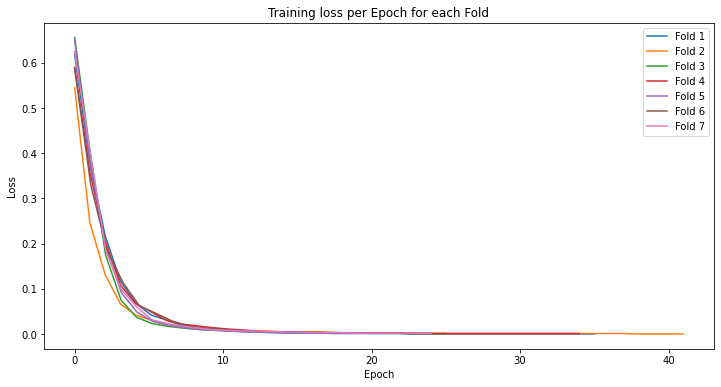

In [106]:
# Plot loss per epoch
plt.figure(figsize=(12, 6))
n_epochs = [len(losses) for losses in losses_per_epoch] # Lista que tiene las épocas a las que llego cada fold * 3 prints para cada epoch
for n_epochs, fold_losses in zip(n_epochs, losses_per_epoch):
    plt.plot(np.linspace(0, n_epochs, n_epochs), fold_losses, label=f'Fold {losses_per_epoch.index(fold_losses) + 1}')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training loss per Epoch for each Fold')
plt.legend()
plt.savefig(f'{figures_exp_path}/losses')
plt.show()

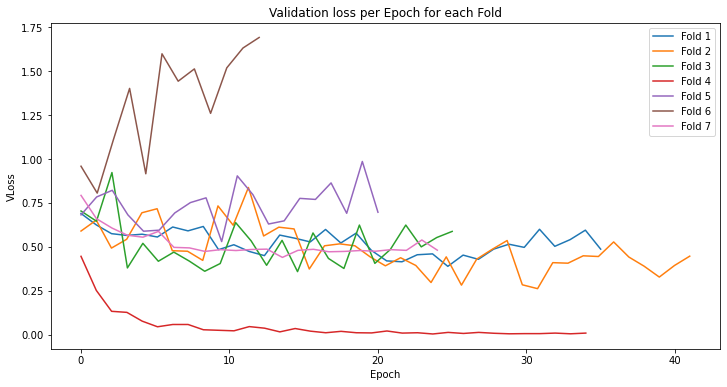

In [107]:
# Plot vloss per epoch
plt.figure(figsize=(12, 6))
n_epochs = [len(losses) for losses in vlosses_per_epoch] # Lista que tiene las épocas a las que llego cada fold * 3 prints para cada epoch
for n_epochs, fold_losses in zip(n_epochs, vlosses_per_epoch):
    plt.plot(np.linspace(0, n_epochs, n_epochs), fold_losses, label=f'Fold {vlosses_per_epoch.index(fold_losses) + 1}')
plt.xlabel('Epoch')
plt.ylabel('VLoss')
plt.title('Validation loss per Epoch for each Fold')
plt.legend()
plt.savefig(f'{figures_exp_path}/vlosses')
plt.show()

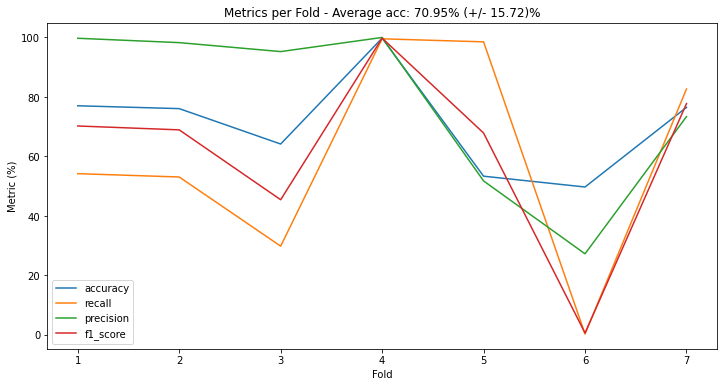

In [108]:
# Plot accuracy per fold
plt.figure(figsize=(12, 6))
for metric, values in results.items():
  if metric == 'accuracy':
    mean, std = np.mean(values), np.std(values)
  plt.plot(range(1, groupk_folds + 1), values, label=f'{metric}')
plt.xlabel('Fold')
plt.ylabel('Metric (%)')
plt.title(f'Metrics per Fold - Average acc: {mean:.2f}% (+/- {std:.2f})%')
plt.legend()
plt.savefig(f'{figures_exp_path}/metrics')
plt.show()

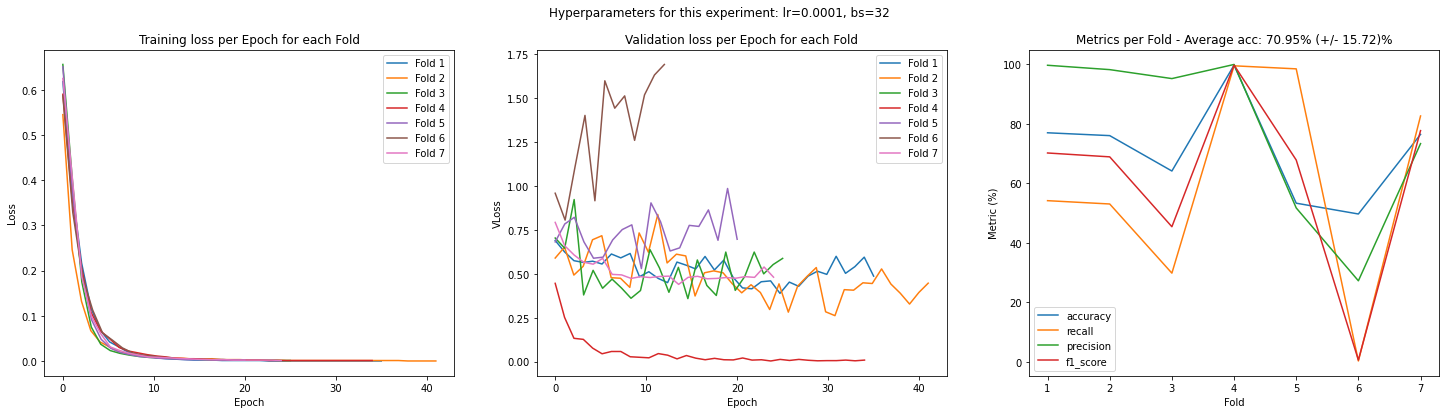

In [109]:
# Crear la figura y los subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(25, 6))

# Plot 1: Loss per epoch
n_epochs = [len(losses) for losses in losses_per_epoch] # Lista que tiene las épocas a las que llego cada fold * 3 prints para cada epoch
for n_epochs, fold_losses in zip(n_epochs, losses_per_epoch):
    ax1.plot(np.linspace(0, n_epochs, n_epochs), fold_losses, label=f'Fold {losses_per_epoch.index(fold_losses) + 1}')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training loss per Epoch for each Fold')
ax1.legend()

# Plot 2: Vloss per epoch
n_epochs = [len(losses) for losses in vlosses_per_epoch] # Lista que tiene las épocas a las que llego cada fold * 3 prints para cada epoch
for n_epochs, fold_losses in zip(n_epochs, vlosses_per_epoch):
    ax2.plot(np.linspace(0, n_epochs, n_epochs), fold_losses, label=f'Fold {vlosses_per_epoch.index(fold_losses) + 1}')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('VLoss')
ax2.set_title('Validation loss per Epoch for each Fold')
ax2.legend()

# Plot 3: Metrics per fold
for metric, values in results.items():
    if metric == 'accuracy':
        mean, std = np.mean(values), np.std(values)
    ax3.plot(range(1, groupk_folds + 1), values, label=f'{metric}')
ax3.set_xlabel('Fold')
ax3.set_ylabel('Metric (%)')
ax3.set_title(f'Metrics per Fold - Average acc: {mean:.2f}% (+/- {std:.2f})%')
ax3.legend()

# Título principal
fig.suptitle(f'Hyperparameters for this experiment: lr={LEARNING_RATE}, bs={BATCH_SIZE}')

# Guardar y mostrar la figura
plt.savefig(f'{figures_exp_path}/combined_metrics')
plt.show()